In [1]:
import sys

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import h5py

from unfold import weighted_binary_crossentropy
from get_np_arrays import *
from process_functions import *

import os
os.environ['CUDA_VISIBLE_DEVICES']="3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], True)

from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
label = {}
label['sys0'] = 'HFS scale (in jet)'
label['sys1'] = 'HFS scale (remainder)'
label['sys5'] = 'HFS $\phi$ angle' 
label['sys7'] = 'Lepton energy scale'
label['sys11'] = 'Lepton $\phi$ angle'
label['QED']  = 'QED rad corr.'
keys=['sys0','sys1','sys5','sys7','sys11']

#label['sys4'] = 'HFS polar angle'
#label['sys10'] = 'Lepton polar angle'
#label['QED'] = 'QED rad corr.'

In [3]:
mc_names = ['Rapgap','Rapgap','Rapgap','Rapgap','Rapgap','Rapgap'] 
mc_tags = ['nominal','sys_0','sys_1','sys_5','sys_7','sys_11']

In [4]:
#base_string = Feb20_syssys_11Rapgap_sys_11_NNweights_step2_Pass3.npy

In [5]:
re_avg_passes = False

if re_avg_passes:
    n_passes = 5

    for sys in mc_tags[1:]:
        print(sys)
        pass_avg_weight = []
        for p in range(n_passes):
            file = f"models/Feb20_sys{sys}Rapgap_{sys}_NNweights_step2_Pass{p}.npy"
            pass_avg_weight.append(np.load(file))
    
        pass_avg_weight = np.mean(pass_avg_weight,axis=0)
        print(np.shape(pass_avg_weight))
        np.save(f"Iter20_Rapgap_{sys}_PassAverage",pass_avg_weight)

## Get npy files of $q_\perp, \phi$ and OmniFold weights

In [6]:
#Calculate q_perp and asymmetry for ALL the variations. save as NPY
reprocess_systematics = False
if (reprocess_systematics):
    for mc_i in range(len(mc_names)):
        mc_name = mc_names[mc_i]
        mc_tag = mc_tags[mc_i]
        mc_label = mc_name+"_"+mc_tag
    
        print("on sample:",mc_name,mc_tag)
        npy_from_pkl(mc_label)
        print("\n\n")

In [7]:
q_max = 10.0
q_perp_bins = np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8., 10.])
N_Bins = len(q_perp_bins)-1

In [8]:
print(q_perp_bins)

[ 0.  1.  2.  3.  4.  5.  6.  8. 10.]


## Load the Main Rapgap

In [9]:
#Data Unfolded From Rapgap
iteration = 29 #See Iterations Notebook for minimum
#iteration = 13 #See Iterations Notebook for minimum

cuts_h1rpgp       = np.load('from_rapgap_cuts.npy')
jet_pT_h1rpgp     = np.load('from_rapgap_jet_pT.npy')[cuts_h1rpgp]
q_perp_h1rpgp     = np.load('from_rapgap_q_perp.npy')[cuts_h1rpgp]
asymm_phi_h1rpgp  = np.load('from_rapgap_asymm_angle.npy')[cuts_h1rpgp]
mc_weights_h1rpgp = np.load("from_rapgap_mc_weights.npy")[cuts_h1rpgp]
weights_h1rpgp    = np.load('from_rapgap_weights.npy')[cuts_h1rpgp]
nn_weights_h1rpgp = np.load("from_rapgap_nn_weights.npy")[cuts_h1rpgp]
#nn_weights_h1rpgp = np.load("../models/Rapgap_NNweights_step2_iteration_{}.npy".format(iteration))[cuts_h1rpgp]
#nn_weights_h1rpgp = np.load("../models/Rapgap_FasterLR_Patience20_NNweights_step2_iteration_{}.npy".format(iteration))[cuts_h1rpgp]
#nn_weights_h1rpgp = np.load("")[cuts_h1rpgp]

weights_h1rpgp = mc_weights_h1rpgp * nn_weights_h1rpgp

btstrp_errors = np.load("Iter20_bootstrap_errors.pkl",allow_pickle=True)

## Load the Systematic Variations

In [10]:
nominal = {}
nominal_cuts   = np.load("npy_files/Rapgap_nominal_cuts.npy")                                                                                                                                                                                                                     
nominal_q_perp    = np.load("npy_files/Rapgap_nominal_q_perp.npy")[nominal_cuts]                                                                                                                                                                                                        
nominal_asymm_phi = np.load("npy_files/Rapgap_nominal_asymm_angle.npy")[nominal_cuts]                                                                                                                                                                                                   
nominal_weights   = np.load("npy_files/Rapgap_nominal_weights.npy")[nominal_cuts]                                                                                                                                                                                                       
averages_in_qperp_bins(nominal, q_perp_bins, nominal_q_perp, nominal_asymm_phi,nominal_weights)
#NOTE: Not switching to the improved ITeration until talking with Ben. As of 12/22

sys0 = {}
sys0_cuts      = np.load("npy_files/Rapgap_sys_0_cuts.npy")                                                                                                                                                                                                                     
sys0_q_perp    = np.load("npy_files/Rapgap_sys_0_q_perp.npy")[sys0_cuts]                                                                                                                                                                                                        
sys0_asymm_phi = np.load("npy_files/Rapgap_sys_0_asymm_angle.npy")[sys0_cuts]                                                                                                                                                                                                   
sys0_mc_weights= np.load("npy_files/Rapgap_sys_0_weights.npy")[sys0_cuts]
sys0_nn_weights= np.load("npy_files/Iter20_Rapgap_sys_0_PassAverage.npy")[sys0_cuts]
sys0_weights = sys0_mc_weights*sys0_nn_weights
averages_in_qperp_bins(sys0, q_perp_bins, sys0_q_perp, sys0_asymm_phi,sys0_weights)                                                                                                                                                                                                  

sys1 = {}
sys1_cuts      = np.load("npy_files/Rapgap_sys_1_cuts.npy")                                                                                                                                                                                                                     
sys1_q_perp    = np.load("npy_files/Rapgap_sys_1_q_perp.npy")[sys1_cuts]                                                                                                                                                                                                        
sys1_asymm_phi = np.load("npy_files/Rapgap_sys_1_asymm_angle.npy")[sys1_cuts]                                                                                                                                                                                                   
sys1_weights   = np.load("npy_files/Rapgap_sys_1_weights.npy")[sys1_cuts]
sys1_mc_weights= np.load("npy_files/Rapgap_sys_1_weights.npy")[sys1_cuts]
sys1_nn_weights= np.load("npy_files/Iter20_Rapgap_sys_1_PassAverage.npy")[sys1_cuts]
sys1_weights = sys1_mc_weights*sys1_nn_weights
averages_in_qperp_bins(sys1, q_perp_bins, sys1_q_perp, sys1_asymm_phi,sys1_weights)                                                                                                                                                                                                  

sys5 = {}
sys5_cuts      = np.load("npy_files/Rapgap_sys_5_cuts.npy")                                                                                                                                                                                                                     
sys5_q_perp    = np.load("npy_files/Rapgap_sys_5_q_perp.npy")[sys5_cuts]                                                                                                                                                                                                        
sys5_asymm_phi = np.load("npy_files/Rapgap_sys_5_asymm_angle.npy")[sys5_cuts]                                                                                                                                                                                                   
sys5_weights   = np.load("npy_files/Rapgap_sys_5_weights.npy")[sys5_cuts]
sys5_mc_weights= np.load("npy_files/Rapgap_sys_5_weights.npy")[sys5_cuts]
sys5_nn_weights= np.load("npy_files/Iter20_Rapgap_sys_5_PassAverage.npy")[sys5_cuts]
sys5_weights = sys5_mc_weights*sys5_nn_weights                                                                                                                                                                                                      
averages_in_qperp_bins(sys5, q_perp_bins, sys5_q_perp, sys5_asymm_phi,sys5_weights)                                                                                                                                                                                                  

sys7 = {}
sys7_cuts      = np.load("npy_files/Rapgap_sys_7_cuts.npy")                                                                                                                                                                                                                     
sys7_q_perp    = np.load("npy_files/Rapgap_sys_7_q_perp.npy")[sys7_cuts]                                                                                                                                                                                                        
sys7_asymm_phi = np.load("npy_files/Rapgap_sys_7_asymm_angle.npy")[sys7_cuts]                                                                                                                                                                                                   
sys7_weights   = np.load("npy_files/Rapgap_sys_7_weights.npy")[sys7_cuts]
sys7_mc_weights= np.load("npy_files/Rapgap_sys_7_weights.npy")[sys7_cuts]
sys7_nn_weights= np.load("npy_files/Iter20_Rapgap_sys_7_PassAverage.npy")[sys7_cuts]
sys7_weights = sys7_mc_weights*sys7_nn_weights                                                                                                                                                                                                       
averages_in_qperp_bins(sys7, q_perp_bins, sys7_q_perp, sys7_asymm_phi,sys7_weights)                                                                                                                                                                                                  

sys11 = {}
sys11_cuts      = np.load("npy_files/Rapgap_sys_11_cuts.npy")                                                                                                                                                                                                                   
sys11_q_perp    = np.load("npy_files/Rapgap_sys_11_q_perp.npy")[sys11_cuts]                                                                                                                                                                                                     
sys11_asymm_phi = np.load("npy_files/Rapgap_sys_11_asymm_angle.npy")[sys11_cuts]                                                                                                                                                                                                
sys11_weights   = np.load("npy_files/Rapgap_sys_11_weights.npy")[sys11_cuts]
sys11_mc_weights= np.load("npy_files/Rapgap_sys_11_weights.npy")[sys11_cuts]
sys11_nn_weights= np.load("npy_files/Iter20_Rapgap_sys_11_PassAverage.npy")[sys11_cuts]
sys0_weights = sys11_mc_weights*sys11_nn_weights
averages_in_qperp_bins(sys11, q_perp_bins, sys11_q_perp, sys11_asymm_phi,sys11_weights)

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


# Get Model Systematics: Bias of Unfolding Procedure

In [11]:
cuts       = np.load('cuts.npy')
q_perp     = np.load('q_perp.npy')[cuts]
asymm_phi  = np.load('asymm_angle.npy')[cuts]
weights    = np.load('weights.npy')[cuts]
mc_weights = np.load("mc_weights.npy")[cuts]
nn_weights = np.load("nn_weights.npy")[cuts]
nn_weights = np.load("Iter20_Django_nominal_Feb14.npy")[cuts]
#nn_weights = np.load("../models/Django_NNweights_step2_iteration_{}.npy".format(iteration))[cuts]
#nn_weights = np.load("../models/Django_NNweights_step2_iteration_{}.npy".format(iteration))[cuts]
#nn_weights = np.load("../models/Django_FasterLR_Patience20_NNweights_step2_iteration_{}.npy".format(iteration))[cuts]

weights = mc_weights * nn_weights

h1_djgo = {}
averages_in_qperp_bins(h1_djgo, q_perp_bins, q_perp, asymm_phi,weights)

h1_rpgp = {}
averages_in_qperp_bins(h1_rpgp, q_perp_bins, q_perp_h1rpgp, asymm_phi_h1rpgp, weights_h1rpgp)

model_difference = {}
for key in ["q_perp","phi","cos1","cos2","cos3"]:
    model_difference[key] = np.abs(h1_rpgp[key]-h1_djgo[key])

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


#### Footnote: What's the original difference between RAPGAP and DJANGO, contextualize model systematic
note: we use only have to change _weights_ $\rightarrow$ _mc_weights_

In [12]:
rapgap = {}
averages_in_qperp_bins(rapgap, q_perp_bins, q_perp_h1rpgp, asymm_phi_h1rpgp, mc_weights_h1rpgp)
django = {}
averages_in_qperp_bins(django, q_perp_bins, q_perp, asymm_phi,mc_weights)

original_difference = {}
for key in ["q_perp","phi","cos1","cos2","cos3"]:
    original_difference[key] = np.abs(rapgap[key]-django[key])

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


# QED Radiation Correction

In [13]:
recalc_QED_npy = False
if (recalc_QED_npy):
    QED_path = "/clusterfs/ml4hep_nvme2/ftoralesacosta/h1_check/h1_lepton_jet_asymmetry/"
    for QED_label in ["Rapgap_nominal_Rady", "Rapgap_nominal_noRady", "Django_nominal_Rady", "Django_nominal_noRady"]:
        npy_from_pkl(QED_label,False,QED_path)

In [14]:
QED_Rapgap_Rady = {}                                                                                                                           
Rapgap_Rady_cuts   = np.load("npy_files/Rapgap_nominal_Rady_cuts.npy")   
Rapgap_Rady_q_perp    = np.load("npy_files/Rapgap_nominal_Rady_q_perp.npy")[Rapgap_Rady_cuts]   
Rapgap_Rady_asymm_phi = np.load("npy_files/Rapgap_nominal_Rady_asymm_angle.npy")[Rapgap_Rady_cuts]   
Rapgap_Rady_weights   = np.load("npy_files/Rapgap_nominal_Rady_weights.npy")[Rapgap_Rady_cuts]   
averages_in_qperp_bins(QED_Rapgap_Rady, q_perp_bins, Rapgap_Rady_q_perp, Rapgap_Rady_asymm_phi,Rapgap_Rady_weights)   
   
QED_Rapgap_noRady = {}   
Rapgap_noRady_cuts   = np.load("npy_files/Rapgap_nominal_noRady_cuts.npy")   
Rapgap_noRady_q_perp    = np.load("npy_files/Rapgap_nominal_noRady_q_perp.npy")[Rapgap_noRady_cuts]   
Rapgap_noRady_asymm_phi = np.load("npy_files/Rapgap_nominal_noRady_asymm_angle.npy")[Rapgap_noRady_cuts]   
Rapgap_noRady_weights   = np.load("npy_files/Rapgap_nominal_noRady_weights.npy")[Rapgap_noRady_cuts]   
averages_in_qperp_bins(QED_Rapgap_noRady, q_perp_bins, Rapgap_noRady_q_perp, Rapgap_noRady_asymm_phi,Rapgap_noRady_weights)   
   
QED_Django_Rady = {}   
Django_Rady_cuts   = np.load("npy_files/Django_nominal_Rady_cuts.npy")   
Django_Rady_q_perp    = np.load("npy_files/Django_nominal_Rady_q_perp.npy")[Django_Rady_cuts]   
Django_Rady_asymm_phi = np.load("npy_files/Django_nominal_Rady_asymm_angle.npy")[Django_Rady_cuts]   
Django_Rady_weights   = np.load("npy_files/Django_nominal_Rady_weights.npy")[Django_Rady_cuts]   
averages_in_qperp_bins(QED_Django_Rady, q_perp_bins, Django_Rady_q_perp, Django_Rady_asymm_phi,Django_Rady_weights)   
   
QED_Django_noRady = {}   
Django_noRady_cuts   = np.load("npy_files/Django_nominal_noRady_cuts.npy")   
Django_noRady_q_perp    = np.load("npy_files/Django_nominal_noRady_q_perp.npy")[Django_noRady_cuts]   
Django_noRady_asymm_phi = np.load("npy_files/Django_nominal_noRady_asymm_angle.npy")[Django_noRady_cuts]   
Django_noRady_weights   = np.load("npy_files/Django_nominal_noRady_weights.npy")[Django_noRady_cuts]   
averages_in_qperp_bins(QED_Django_noRady, q_perp_bins, Django_noRady_q_perp, Django_noRady_asymm_phi,Django_noRady_weights) 

Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8
Keys = dict_keys(['q_perp', 'phi', 'cos1', 'cos2', 'sin1', 'cos3']) N_Bins =  8


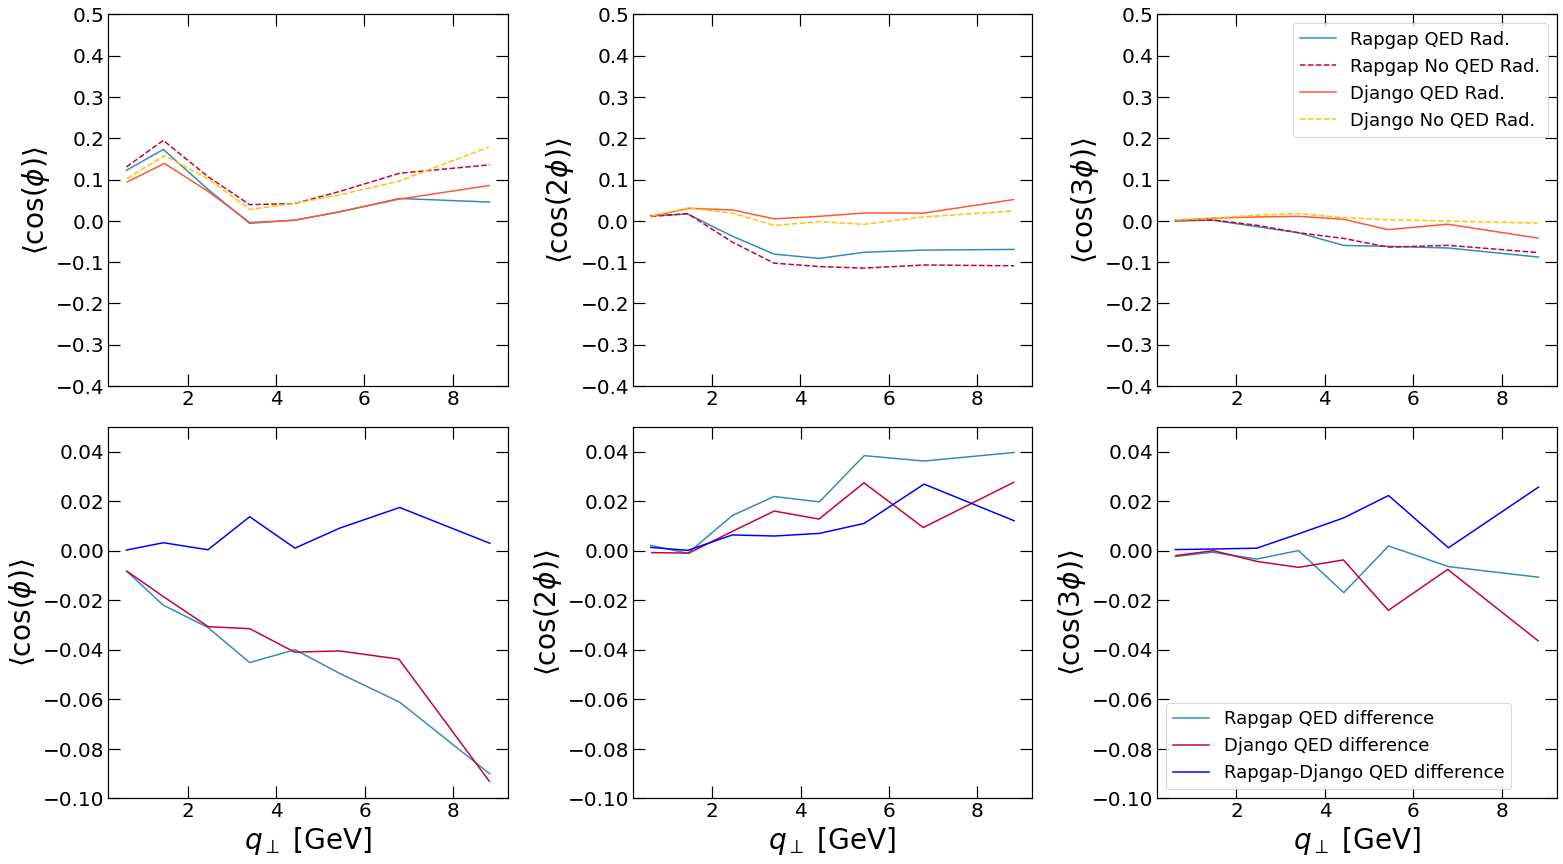

In [15]:
QED_differences = {}
for i,key in enumerate(["q_perp","phi","cos1","cos2","cos3"]):
    Rapgap_difference = np.abs(QED_Rapgap_Rady[key]-QED_Rapgap_noRady[key])
    Django_difference = np.abs(QED_Django_Rady[key]-QED_Django_noRady[key])
    QED_differences[key] = np.abs(Rapgap_difference-Django_difference)
    
fig,axes = plt.subplots(2,3,figsize=(22,12))
axes = axes.ravel()
for i in range(3):
    key = "cos%i"%(i+1)
    string = r"$\langle\cos(%i\phi)\rangle$"%(i+1)
    string = string.replace("1","")
    
    axes[i].plot(QED_Rapgap_Rady["q_perp"],QED_Rapgap_Rady[key],label="Rapgap QED Rad.")
    axes[i].plot(QED_Rapgap_noRady["q_perp"],QED_Rapgap_noRady[key],linestyle="--",label="Rapgap No QED Rad.")
    axes[i].plot(QED_Django_Rady["q_perp"],QED_Django_Rady[key],label="Django QED Rad.")
    axes[i].plot(QED_Django_noRady["q_perp"],QED_Django_noRady[key],linestyle="--",label="Django No QED Rad.")
    axes[i].set_ylim(-0.4,0.5)
    axes[i].set_ylabel(string,fontsize=28)
    
    axes[i+3].plot(QED_Rapgap_Rady["q_perp"],QED_Rapgap_Rady[key]-QED_Rapgap_noRady[key],label="Rapgap QED difference")
    axes[i+3].plot(QED_Django_Rady["q_perp"],QED_Django_Rady[key]-QED_Django_noRady[key],label="Django QED difference")
    axes[i+3].plot(QED_Rapgap_Rady["q_perp"],QED_differences[key],color="blue",label="Rapgap-Django QED difference")
    axes[i+3].set_ylim(-0.1,0.05)
    axes[i+3].set_ylabel(string,fontsize=28)
    axes[i+3].set_xlabel("$q_\perp$ [GeV]",fontsize=28)

axes[2].legend(fontsize=18)
axes[5].legend(fontsize=18)
plt.tight_layout()


___

## Pickle Dictionaries

In [16]:
# open a file, where you ant to store the data
file = open('Iter20_nominal_binned.pkl', 'wb')
pickle.dump(nominal, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('Iter20_sys0_binned.pkl', 'wb')
pickle.dump(sys0, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('Iter20_sys1_binned.pkl', 'wb')
pickle.dump(sys1, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('Iter20_sys5_binned.pkl', 'wb')
pickle.dump(sys5, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('Iter20_sys7_binned.pkl', 'wb')
pickle.dump(sys7, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close()

file = open('Iter20_sys11_binned.pkl', 'wb')
pickle.dump(sys11, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close()

# Consolidate Systematics, and Sum in Quadrature

In [17]:
dicts = {}
dicts['sys0'] = sys0
dicts['sys1'] = sys1
dicts['sys5'] = sys5
dicts['sys7'] = sys7
dicts['sys11'] = sys11
dicts['nominal'] = nominal

In [18]:
systematics = {}
systematics['sys0']  = {key: np.abs(nominal[key] - sys0.get(key, 0))  for key in nominal.keys()}
systematics['sys1']  = {key: np.abs(nominal[key] - sys1.get(key, 0))  for key in nominal.keys()}
systematics['sys5']  = {key: np.abs(nominal[key] - sys5.get(key, 0))  for key in nominal.keys()}
systematics['sys7']  = {key: np.abs(nominal[key] - sys7.get(key, 0))  for key in nominal.keys()}
systematics['sys11'] = {key: np.abs(nominal[key] - sys11.get(key,0))  for key in nominal.keys()}
systematics['model'] = model_difference
systematics['QED']   = QED_differences 
file = open('Iter20_systematics.pkl', 'wb')
pickle.dump(systematics, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close() 

In [19]:
total_sys = {}
total_minus_model = {}
for key in ["q_perp","phi","cos1","cos2","cos3"]:
    total_sys[key] = (nominal[key]-sys0[key])**2
    total_sys[key] += (nominal[key]-sys1[key])**2
    total_sys[key] += (nominal[key]-sys5[key])**2
    total_sys[key] += (nominal[key]-sys7[key])**2
    total_sys[key] += (nominal[key]-sys11[key])**2
    total_sys[key] += QED_differences[key]**2
    total_minus_model[key] = np.sqrt(total_sys[key])
    
    total_sys[key] += model_difference[key]**2
    total_sys[key] = np.sqrt(total_sys[key])
    
systematics['total_no_model'] = total_minus_model
systematics['total'] = total_sys
    
file = open('Iter20_systematics.pkl', 'wb')
pickle.dump(systematics, file,protocol=pickle.HIGHEST_PROTOCOL)
file.close() 

In [20]:
print(systematics['total'])

{'q_perp': array([0.04441364, 0.05429422, 0.0199282 , 0.00543685, 0.01863072,
       0.00362869, 0.02303177, 0.02294747]), 'phi': array([0.15933552, 0.31680134, 0.37026196, 0.34162352, 0.2557917 ,
       0.22559353, 0.28409427, 0.43169294]), 'cos1': array([0.12450514, 0.24682016, 0.28947527, 0.26766734, 0.20342629,
       0.18125346, 0.22752714, 0.34449461]), 'cos2': array([0.08096258, 0.13110928, 0.0694132 , 0.04863888, 0.02784911,
       0.06815398, 0.09967965, 0.09698712]), 'cos3': array([0.00889933, 0.01889996, 0.01539584, 0.02376902, 0.04332904,
       0.04914762, 0.05319099, 0.07807297])}


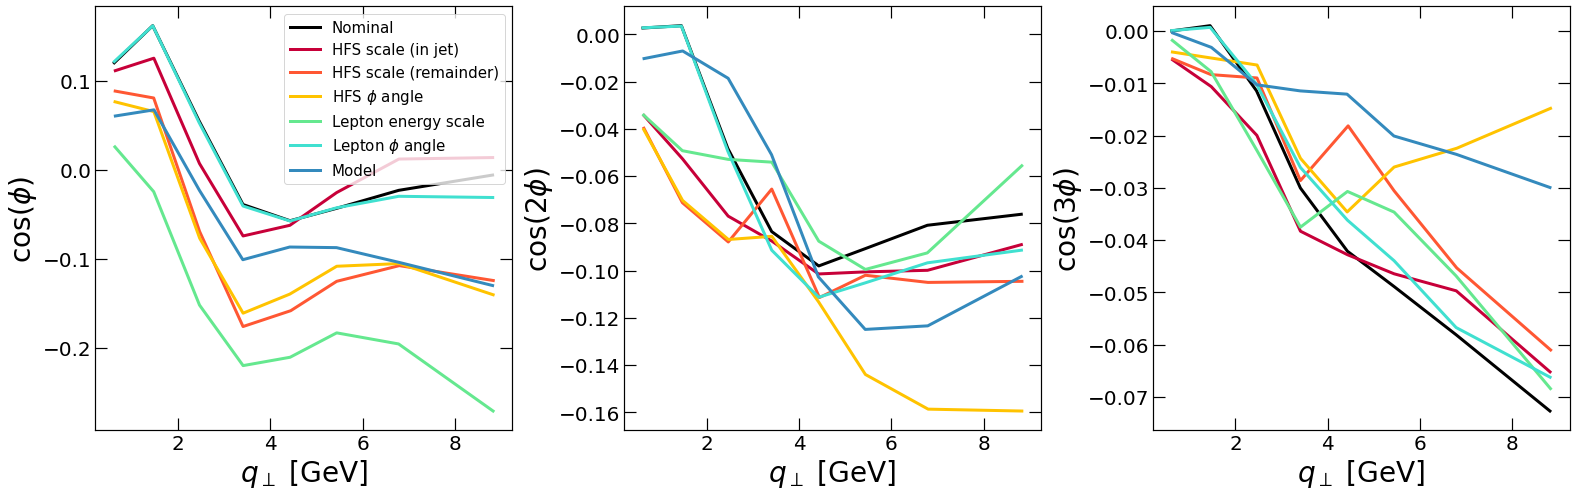

In [21]:
keys=["q_perp","cos1","cos2","cos3"]
colors = ['#348ABD','#C70039','#FF5733','#FFC300','#65E88F','#40E0D0']
fig,axes = plt.subplots(1,3,figsize=(22,7))
#fig = plt.figure(figsize=(10,8))
#colors=["blue","purple","red"]


for i,key in enumerate(keys[1:]):
    axes[i].errorbar(nominal["q_perp"],nominal[key],
                     label="Nominal",color="k",linewidth=3)
    
    axes[i].errorbar(sys0["q_perp"],sys0[key],
                     label=label['sys0'],color=colors[1],linewidth=3)
    
    axes[i].errorbar(sys1["q_perp"],sys1[key],
                     label=label['sys1'],color=colors[2],linewidth=3)
    
    axes[i].errorbar(sys5["q_perp"],sys5[key],
                     label=label['sys5'],color=colors[3],linewidth=3)
    
    axes[i].errorbar(sys7["q_perp"],sys7[key],
                     label=label['sys7'],color=colors[4],linewidth=3)
    
    axes[i].errorbar(sys11["q_perp"],sys11[key],
                     label=label['sys11'],color=colors[5],linewidth=3)
    
    axes[i].errorbar(h1_djgo["q_perp"],h1_djgo[key],
                     label='Model',color=colors[0],linewidth=3) #Django instead of Rapgap
    
    string = r"$\cos(%i\phi)$"%(i+1)
    string = string.replace("1","")
    axes[i].set_ylabel(string,fontsize=28)
    axes[i].set_xlabel("$q_\perp$ [GeV]",fontsize=28)
    axes[0].legend(fontsize=15)


plt.tight_layout()
plt.savefig("Iter20_systematics_unfolded_separately.pdf")

In [27]:
file = open('relative_bootstrap_errors.pkl', 'rb')
bootstrap_errors = pickle.load(file)
file.close()

file = open('Iter20_bootstrap_errors.pkl', 'rb')
abs_bootstrap_errors = pickle.load(file)
file.close()

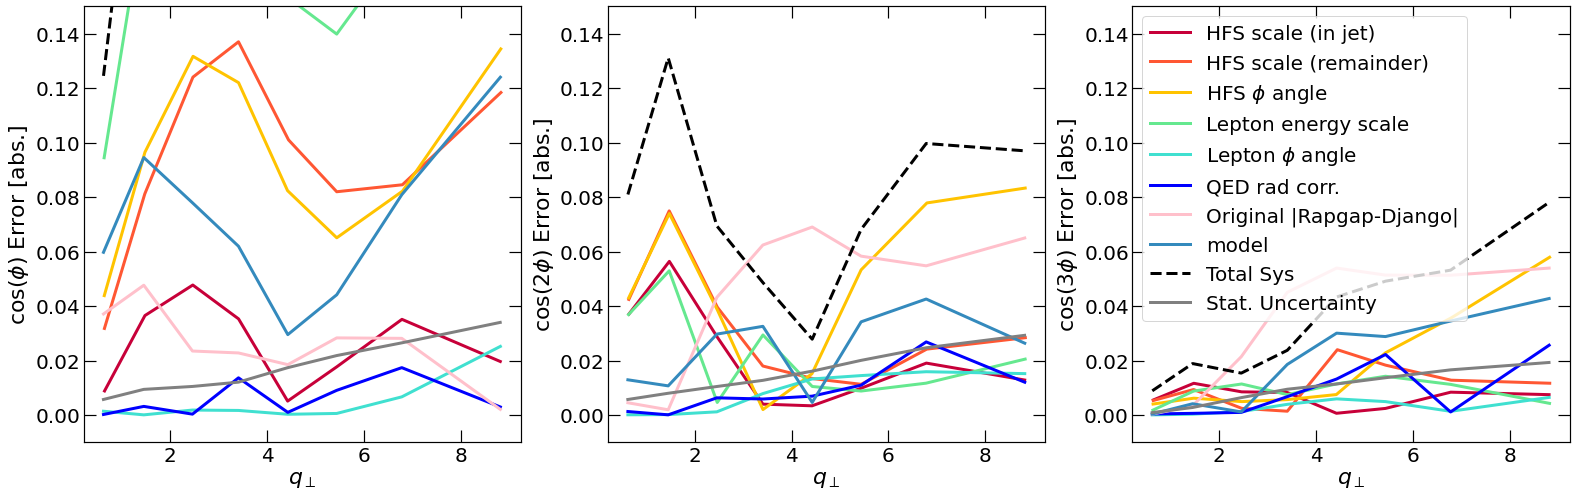

In [29]:
keys=["q_perp","cos1","cos2","cos3"]
colors = ['#348ABD','#C70039','#FF5733','#FFC300','#65E88F','#40E0D0']
fig,axes = plt.subplots(1,3,figsize=(22,7))
#fig = plt.figure(figsize=(10,8))
#colors=["blue","purple","red"]

plot_model = True
plot_bootstrap = True
plot_original_diff = True

axes[0].set_ylim(-0.01,0.15)
axes[1].set_ylim(-0.01,0.15)
axes[2].set_ylim(-0.01,0.15)

for i,key in enumerate(keys[1:]):
    
    axes[i].errorbar(sys0["q_perp"],np.abs(nominal[key] - sys0[key]),
                     label=label['sys0'],color=colors[1],linewidth=3)
                                                   
    axes[i].errorbar(sys1["q_perp"],np.abs(nominal[key] - sys1[key]),
                     label=label['sys1'],color=colors[2],linewidth=3)
                                                   
    axes[i].errorbar(sys5["q_perp"],np.abs(nominal[key] - sys5[key]),
                     label=label['sys5'],color=colors[3],linewidth=3)
                                                   
    axes[i].errorbar(sys7["q_perp"],np.abs(nominal[key] - sys7[key]),
                     label=label['sys7'],color=colors[4],linewidth=3)
                                                   
    axes[i].errorbar(sys11["q_perp"],np.abs(nominal[key] - sys11[key]),
                     label=label['sys11'],color=colors[5],linewidth=3)
    
    axes[i].errorbar(sys11["q_perp"],QED_differences[key],
                     label='QED rad corr.',color="blue",linewidth=3)
    
    if (plot_original_diff):
        axes[i].errorbar(sys11["q_perp"],original_difference[key],
                    label="Original |Rapgap-Django|",color="pink",linewidth=3)
    
    if (plot_model):
        axes[i].errorbar(sys11["q_perp"],model_difference[key],
                    label="model",color=colors[0],linewidth=3)
    
        axes[i].errorbar(sys11["q_perp"],systematics['total'][key],
                     label='Total Sys',color='k',linewidth=3,ls='--')
    else:
        axes[i].errorbar(sys11["q_perp"],total_minus_model[key],
                     label='Total Sys.',color='k',linewidth=3,ls='--')

        
    if (plot_bootstrap):
        #axes[i].errorbar(nominal["q_perp"],np.abs(bootstrap_errors[key]*nominal[key]),
        #             label="Stat. Uncertainty (R)",color="grey",linestyle="dotted",linewidth=3)
        
        axes[i].errorbar(nominal["q_perp"],np.abs(abs_bootstrap_errors[key]),
                label="Stat. Uncertainty",color="grey",linestyle="-",linewidth=3)
        #axes[0].set_ylim(-0.01,1.5)
        #axes[1].set_ylim(-0.01,1.5)
        #axes[2].set_ylim(-0.01,1.5)
                                                   
    string = r"$\cos(%i\phi)$ Error [abs.]"%(i+1)
    string = string.replace("1","")
    axes[i].set_ylabel(string)
    axes[i].set_xlabel("$q_\perp$")


plt.tight_layout()
plt.legend(fontsize=20)
plt.savefig("absError_systematics_unfolded_separately.pdf")

In [24]:
print(systematics['total']['cos1'])

[0.12450514 0.24682016 0.28947527 0.26766734 0.20342629 0.18125346
 0.22752714 0.34449461]
